In [1]:
!nvidia-smi

Thu Aug  8 08:55:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Setup

In [1]:
# install tensorflow 2.15 since voxelmorph is not compatible with current build
import tensorflow as tf
if not tf.__version__.startswith('2.15'):
  !pip uninstall -y tensorflow
  !pip install tensorflow==2.15
# install voxelmorph
!pip install voxelmorph

  Using cached voxelmorph-0.2-py3-none-any.whl.metadata (660 bytes)
  Using cached neurite-0.2-py3-none-any.whl.metadata (653 bytes)
  Using cached pystrum-0.4.tar.gz (17 kB)
  Preparing metadata (setup.py) ... done
Using cached voxelmorph-0.2-py3-none-any.whl (54 kB)
Using cached neurite-0.2-py3-none-any.whl (108 kB)
  Created wheel for pystrum: filename=pystrum-0.4-py3-none-any.whl size=19535 sha256=297ed5da1ac1c98a14c1c06302bc697ac6b081b4b722ed19623263cc5e71241e
  Stored in directory: /root/.cache/pip/wheels/aa/08/d0/914025beb5a12a855b8aafd22eeedc547198684a3f4409f66c
Successfully built pystrum


In [161]:
import voxelmorph as vxm
import neurite as ne

import os
import urllib.request
import zipfile
import json
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import cv2

from sklearn.model_selection import train_test_split

# Download dataset

In [3]:
# download dataset
filename = 'COMULISSHGBF.zip'
if not os.path.exists(filename):
    url = 'https://cloud.imi.uni-luebeck.de/s/QQKxdTGoLPmEbc4/download/COMULISSHGBF.zip'
    urllib.request.urlretrieve(url, filename)

    # extract files
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('./')

In [4]:
def load_data(jsonData, dataFolderPath, filterString='0001'):
    training_paths = []
    for i in range(len(jsonData['training_paired_images'])):
        tmproot, tmpext = os.path.splitext(jsonData['training_paired_images'][i]['moving'])
        root, ext = os.path.splitext(tmproot)
        splitRoot = root.split('_')
        if splitRoot[-1] == filterString:
            training_paths.append(jsonData['training_paired_images'][i])

    fixedData = []
    movingData = []
    for image in training_paths:
        fixedImg = nib.load(dataFolderPath + image['fixed'].removeprefix('.')).get_fdata()
        fixedData.append(fixedImg.astype(np.uint8))
        movingImg = nib.load(dataFolderPath + image['moving'].removeprefix('.')).get_fdata()
        movingImg_reshaped = movingImg.reshape(jsonData['tensorImageShape'][0]['0'][0], jsonData['tensorImageShape'][0]['0'][1], 3)
        movingData.append(movingImg_reshaped.astype(np.uint8))

    return np.array(fixedData), np.array(movingData)

In [5]:
# load data
with open('./COMULISSHGBF/COMULISSHGBF_dataset.json', 'r') as file:
  data_json = json.load(file)
dataFolder = './COMULISSHGBF'
data_fixed_raw, data_moved_raw = load_data(data_json, dataFolder)

# Preprocess Data

In [6]:
# filter data since some of the fixed images are nearly empty
means = np.mean(data_fixed_raw, axis=(1,2,3))
mask = means >= 3

data_fixed_filtered = data_fixed_raw[mask]
data_moved_filtered = data_moved_raw[mask]

In [48]:
# Resize images
target_size = (512, 512)
data_fixed_resized = []
for sample in data_fixed_filtered:
    data_fixed_resized.append(cv2.resize(sample,target_size))
data_fixed_resized = np.array(data_fixed_resized)

data_moved_resized = []
for sample in data_moved_filtered:
    data_moved_resized.append(cv2.resize(sample,target_size))
data_moved_resized = np.array(data_moved_resized)

In [49]:
data_fixed_resized.shape

(124, 512, 512)

In [52]:
# split dataset
random_state = 10

fixed_train_raw, fixed_test_raw, moved_train_raw, moved_test_raw = train_test_split(data_fixed_resized, data_moved_resized, test_size=0.2, random_state=random_state)
fixed_val_raw, fixed_test_raw, moved_val_raw, moved_test_raw = train_test_split(fixed_test_raw, moved_test_raw, test_size=0.5, random_state=random_state)

In [59]:
fixed_train_raw.shape

(99, 512, 512)

In [54]:
fixed_val_raw.shape

(12, 512, 512)

In [55]:
fixed_test_raw.shape

(13, 512, 512)

(-0.5, 511.5, 511.5, -0.5)

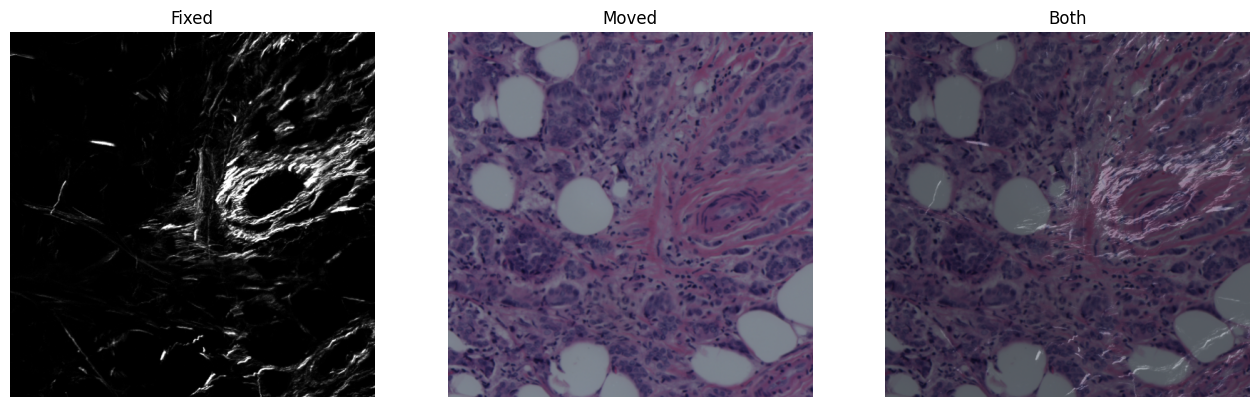

In [156]:
# preview data
img = 1

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16,8))
ax0.imshow(fixed_train_raw[img],cmap='gray')
ax0.set_title("Fixed")
ax0.axis("off")
ax1.imshow(moved_train_raw[img])
ax1.set_title("Moved")
ax1.axis("off")
ax2.imshow(fixed_train_raw[img],cmap='gray')
ax2.imshow(moved_train_raw[img], alpha=0.7)
ax2.set_title("Both")
ax2.axis("off")

In [157]:
def transform_data(fixed, moved):
  fixed = 1 - fixed

  # Get moved images as grayscales
  data_moved_gray = np.zeros_like(fixed)
  for idx, val in enumerate(moved):
      data_moved_gray[idx] = cv2.cvtColor(val, cv2.COLOR_RGB2GRAY)

  # get edges of fixed images
  data_fixed_edges = np.zeros_like(fixed)
  for idx, val in enumerate(fixed):
      canny = cv2.Canny(val,1000,1000)
      data_fixed_edges[idx] = canny

  # get edges of moved images
  data_moved_edges = np.zeros_like(data_moved_gray)
  for idx, val in enumerate(data_moved_gray):
      canny = cv2.Canny(val,50,100)
      data_moved_edges[idx] = canny#cv2.erode(canny, np.ones((5, 5), np.uint8), iterations=1)

  # Normalize images
  return data_fixed_edges / np.max(data_fixed_edges), data_moved_edges / np.max(data_moved_edges)

In [154]:
fixed_train, moved_train = transform_data(fixed_train_raw, moved_train_raw)
fixed_val, moved_val = transform_data(fixed_val_raw, moved_val_raw)
fixed_test, moved_test = transform_data(fixed_test_raw, moved_test_raw)

(-0.5, 511.5, 511.5, -0.5)

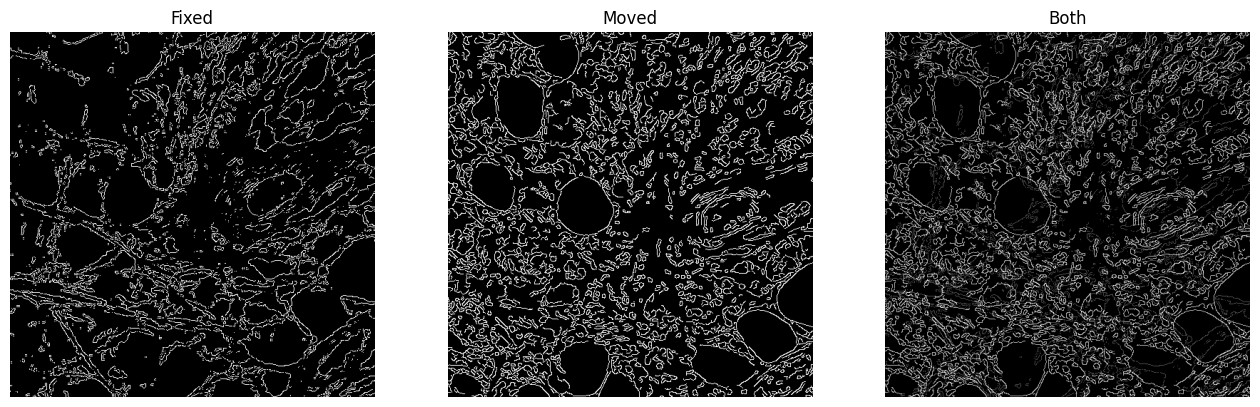

In [158]:
# view preprocessed data
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16,8))
ax0.imshow(fixed_train[img],cmap='gray')
ax0.set_title("Fixed")
ax0.axis("off")
ax1.imshow(moved_train[img], cmap='gray')
ax1.set_title("Moved")
ax1.axis("off")
ax2.imshow(fixed_train[img],cmap='gray')
ax2.imshow(moved_train[img], cmap='gray', alpha=0.7)
ax2.set_title("Both")
ax2.axis("off")

# Define Model

In [159]:
# Define the input shapes
inshape = fixed_test.shape[1:3]
nb_features = [
    [32, 64, 128, 256],  # encoder-channels
    [256, 128, 64, 32, 32]  # eecoder-channels
]

# build model using VxmDense
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

print('input shape: ', ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('output shape:', ', '.join([str(t.shape) for t in vxm_model.outputs]))

input shape:  (None, 512, 512, 1), (None, 512, 512, 1)
output shape: (None, 512, 512, 1), (None, 512, 512, 2)


In [180]:
def mutual_information(hgram):
    pxy = hgram / tf.reduce_sum(hgram)
    px = tf.reduce_sum(pxy, axis=1)  # marginal for x over y
    py = tf.reduce_sum(pxy, axis=0)  # marginal for y over x
    px_py = tf.tensordot(px, py, axes=0)  # Outer product to multiply marginals
    nzs = tf.greater(pxy, 0)  # Only non-zero pxy values contribute to the sum
    return tf.reduce_sum(tf.boolean_mask(pxy, nzs) * tf.math.log(tf.boolean_mask(pxy, nzs) / tf.boolean_mask(px_py, nzs)))

def mutual_information_loss(x, y, bins=32):
    x = tf.reshape(x, [-1])
    y = tf.reshape(y, [-1])

    # Create histogram
    hist_2d = tf.histogram_fixed_width_2d(x, y, value_range=[0.0, 1.0], nbins=bins)

    # Compute Mutual Information
    mi = mutual_information(hist_2d)
    return -mi

In [187]:
# define loss functions
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# balance the two losses with hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]

In [188]:
# compile model
vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

# Train model

In [189]:
# define a data generator that adds augmentation
def vxm_data_generator(fixed, moved, batch_size=32, augmentation=True):
    vol_shape = fixed.shape[1:3]
    ndims = len(vol_shape)

    # prepare a zero array the size of the deformation
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])

    while True:
        idx = np.random.randint(0, fixed.shape[0], size=batch_size)

        fixed_image = fixed[idx, ..., np.newaxis]
        moving_image = moved[idx, ..., np.newaxis]

        if augmentation:
          if np.random.randint(0,2) == 0:
            fixed_image = np.flip(fixed_image,1)
            moving_image = np.flip(moving_image,1)

          for _ in range(np.random.randint(0,4)):
            fixed_image = np.rot90(fixed_image,axes=(1,2))
            moving_image = np.rot90(moving_image,axes=(1,2))

        inputs = [moving_image, fixed_image]
        outputs = [fixed_image, zero_phi]

        yield (inputs, outputs)

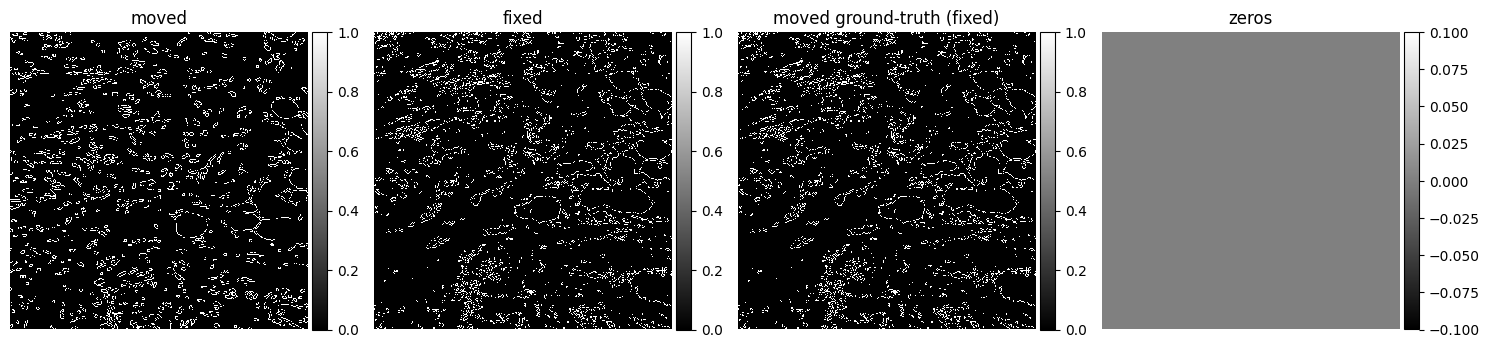

In [190]:
batch_size = 16

# define training generator
train_generator = vxm_data_generator(fixed_train, moved_train, batch_size=batch_size)
in_sample, out_sample = next(train_generator)

# view generated data
images = [img[0, :, :, 0] for img in in_sample + out_sample]
titles = ['moved', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [191]:
# define  validation generator
val_generator = vxm_data_generator(fixed_val, moved_val, batch_size=batch_size)

In [192]:
# train model
nb_epochs = 30
steps_per_epoch = 20
validation_steps = 2
hist = vxm_model.fit(
    train_generator,
    epochs=nb_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    verbose=2
)

Epoch 1/30
20/20 - 21s - loss: 0.1636 - vxm_dense_transformer_loss: 0.1632 - vxm_dense_flow_loss: 0.0083 - val_loss: 0.1332 - val_vxm_dense_transformer_loss: 0.1324 - val_vxm_dense_flow_loss: 0.0161 - 21s/epoch - 1s/step
Epoch 2/30
20/20 - 14s - loss: 0.1430 - vxm_dense_transformer_loss: 0.1412 - vxm_dense_flow_loss: 0.0364 - val_loss: 0.1394 - val_vxm_dense_transformer_loss: 0.1359 - val_vxm_dense_flow_loss: 0.0688 - 14s/epoch - 719ms/step
Epoch 3/30
20/20 - 15s - loss: 0.1263 - vxm_dense_transformer_loss: 0.1232 - vxm_dense_flow_loss: 0.0633 - val_loss: 0.1078 - val_vxm_dense_transformer_loss: 0.1030 - val_vxm_dense_flow_loss: 0.0954 - 15s/epoch - 742ms/step
Epoch 4/30
20/20 - 15s - loss: 0.1144 - vxm_dense_transformer_loss: 0.1093 - vxm_dense_flow_loss: 0.1034 - val_loss: 0.1001 - val_vxm_dense_transformer_loss: 0.0934 - val_vxm_dense_flow_loss: 0.1326 - 15s/epoch - 733ms/step
Epoch 5/30
20/20 - 15s - loss: 0.1090 - vxm_dense_transformer_loss: 0.1013 - vxm_dense_flow_loss: 0.1532 - 

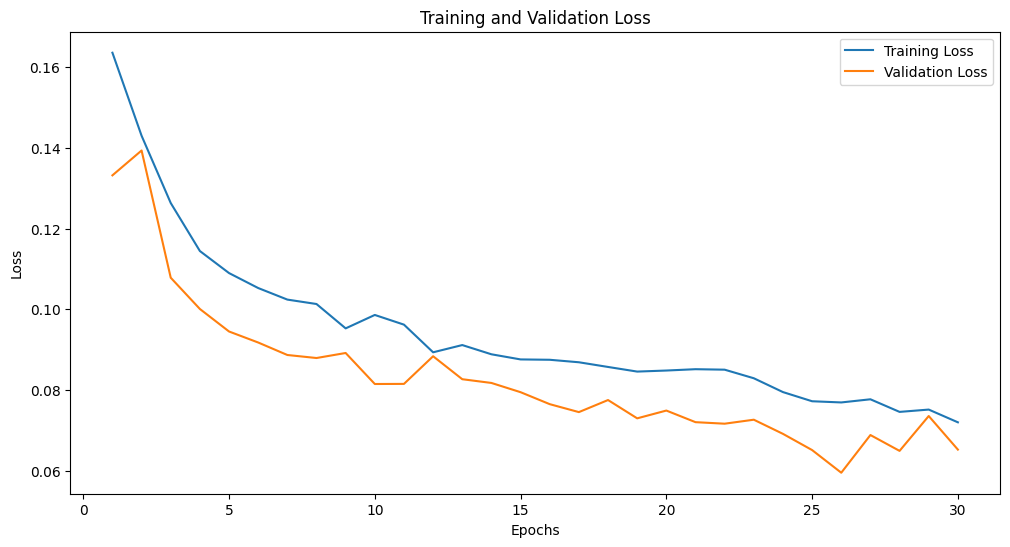

In [193]:
# extract train- and validation-loss
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

# plot history
plt.figure(figsize=(12, 6))
plt.plot(range(1, nb_epochs + 1), train_loss, label='Training Loss')
plt.plot(range(1, nb_epochs + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Test registration

In [238]:
# define validation generator
test_generator = vxm_data_generator(fixed_test, moved_test, batch_size = 1, augmentation=False)
test_input, _ = next(test_generator)

In [239]:
# perform prediction
test_pred = vxm_model.predict(test_input)

1/1 [==============================] - 0s 43ms/step


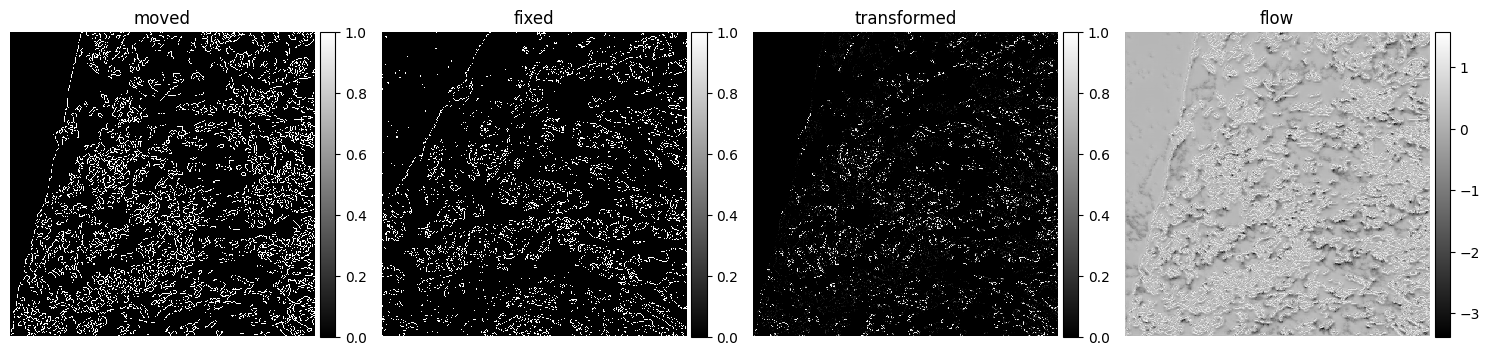

In [240]:
# view result
images = [img[0, :, :, 0] for img in test_input + test_pred]
titles = ['moved', 'fixed', 'transformed', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

(-0.5, 511.5, 511.5, -0.5)

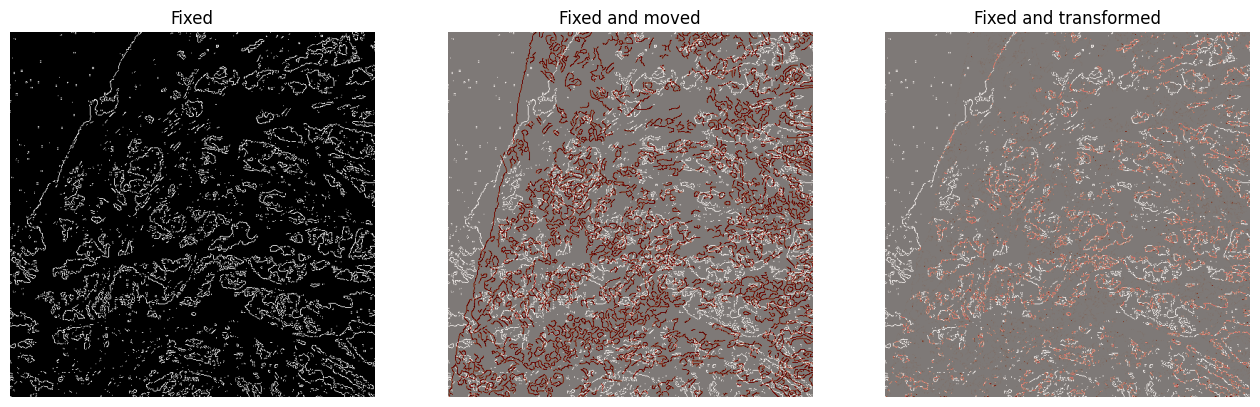

In [241]:
# view results
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16,8))
ax0.imshow(test_input[1][0],cmap='gray')
ax0.set_title("Fixed")
ax0.axis("off")
ax1.imshow(test_input[1][0],cmap='gray')
ax1.imshow(test_input[0][0],cmap='Reds', alpha=0.5)
ax1.set_title("Fixed and moved")
ax1.axis("off")
ax2.imshow(test_input[1][0],cmap='gray')
ax2.imshow(test_pred[0][0],cmap='Reds', alpha=0.5)
ax2.set_title("Fixed and transformed")
ax2.axis("off")

In [242]:
def find_subarray(arr,subarr):
  for idx, val in enumerate(arr):
    if np.array_equal(val, subarr):
      return idx

In [243]:
idx = find_subarray(moved_test, test_input[0][0][:,:,0])

In [244]:
def apply_displacement_field(input_image, displacement_field):
  height, width = input_image.shape

  # Apply displacement field to original resized picture using spatial transformer
  inputs_image = tf.keras.Input(shape=(height, width, 1))
  inputs_disp = tf.keras.Input(shape=(height, width, 2))

  spatial_transformer = vxm.layers.SpatialTransformer(name='transformer')
  moved_image = spatial_transformer([inputs_image, inputs_disp])

  # Define model
  transformer_model = tf.keras.Model(inputs=[inputs_image, inputs_disp], outputs=moved_image)

  # Make prediction
  prediction = transformer_model.predict([np.expand_dims(input_image, axis=0), np.expand_dims(displacement_field, axis=0)])[0]

  return np.squeeze(prediction, axis=-1)

In [248]:
displacement_field = test_pred[1][0]
input_image = moved_test_raw[idx]

predicted_image = np.zeros_like(input_image)

for i in range(3):
  predicted_image[:,:,i] = apply_displacement_field(input_image[:,:,i],displacement_field)

1/1 [==============================] - 0s 233ms/step


(-0.5, 511.5, 511.5, -0.5)

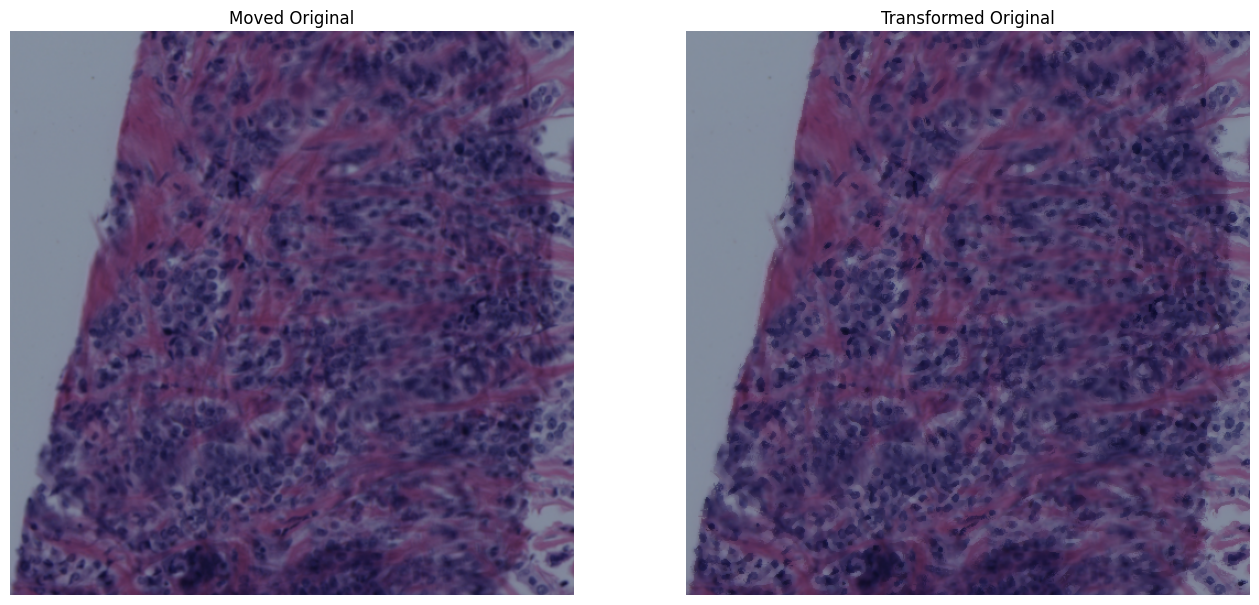

In [250]:
# view applied field on original picture
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16,8))
ax0.imshow(input_image)
ax0.set_title("Moved Original")
ax0.axis("off")
ax1.imshow(predicted_image)
ax1.set_title("Transformed Original")
ax1.axis("off")

(-0.5, 511.5, 511.5, -0.5)

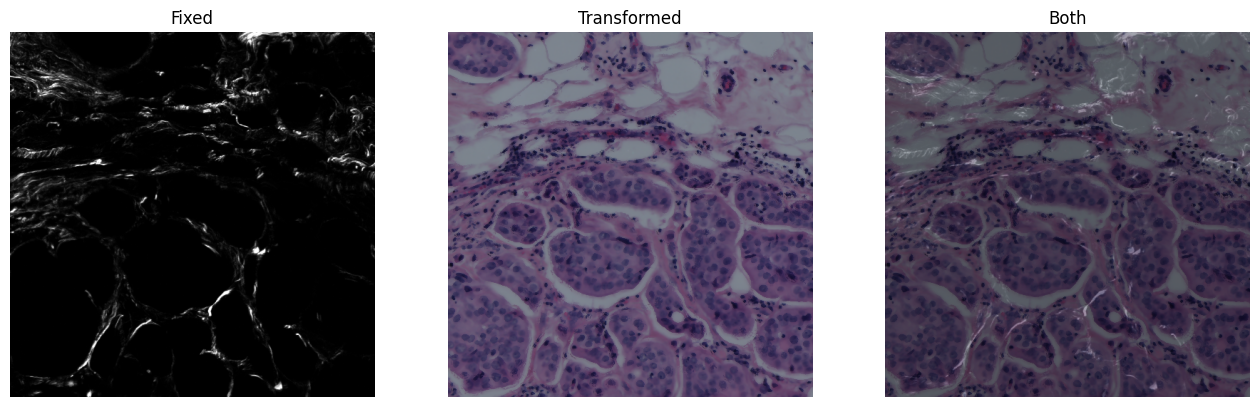

In [219]:
# view final result
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16,8))
ax0.imshow(fixed_test_raw[idx],cmap='gray')
ax0.set_title("Fixed")
ax0.axis("off")
ax1.imshow(predicted_image)
ax1.set_title("Transformed")
ax1.axis("off")
ax2.imshow(fixed_test_raw[idx],cmap='gray')
ax2.imshow(predicted_image, alpha=0.7)
ax2.set_title("Both")
ax2.axis("off")

# Save model

In [231]:
vxm_model.save_weights('MIR_weights.h5')

# Load model